### Exploratory Data Analysis [RQ3]
* Do the all trips last the same? Let's put our attention on the distribution of trip's duration. 
* Provide a plot for it and comment what you see. 
* Run this analysis for NYC and for each borough (and obviously comment the results!).

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#import functions from our file
from rq3_functions import check_types_pretty, calculate_trip_duration 

In [3]:
taxi_zone_lookup = pd.read_csv("taxi_zone_lookup.csv") #reading csv file

#### Let's check how looks like taxi_zone_lookup dataframe

In [4]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


**What are the data types in each column?**

In [5]:
check_types_pretty(taxi_zone_lookup)

* LocationID        		 | <class 'numpy.int64'> 
* Borough           		 | <class 'str'> 
* Zone              		 | <class 'str'> 
* service_zone      		 | <class 'str'> 


** We are especially interested in the information about "Borough".**

In [6]:
print("The unique boroughs are: {}".format(taxi_zone_lookup["Borough"].unique()))

The unique boroughs are: ['EWR' 'Queens' 'Bronx' 'Manhattan' 'Staten Island' 'Brooklyn' 'Unknown']


After preliminary analysis we know that there are six known boroughs, which corresponds to the LocationID column. It has also been noticed that the data contains "Unknown" locations.

### Monthly data analysis 

Here you can find data dictionary for Yellow taxi zone: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

All necessary files are located in working directory.

In order to facilitate the analysis, the most interesting columns in dataframes were selected.

* **tpep_pickup_datetime** - The date and time when the meter was engaged.
* **tpep_dropoff_datetime** -  The date and time when the meter was disengaged. 
* **PULocationID** -  TLC Taxi Zone in which the taximeter was engaged
* **DOLocationID** -  TLC Taxi Zone in which the taximeter was disengaged


In [14]:
#We create a list with the name of the .csv files
taxi_data = ['yellow_tripdata_2018-0'+str(i)+'.csv' for i in range(1,7)]

In [38]:
# Preparing data for each month

# Creating dataframe for prepared data (all months)
trip_duration_all_months_df = pd.DataFrame(data={"duration":[], "PULocationID":[], "DOLocationID":[]})

# Setting the path to the files
path = "D:/"

# Loop for each file
for month_data in taxi_data:
    month_data_df = pd.read_csv(path + month_data)
    
    # Selecting interesting columns
    tmp_trip_duration_df = month_data_df[["tpep_pickup_datetime", "tpep_dropoff_datetime", "PULocationID", "DOLocationID"]]
    
    # Calculating trip duration using before defined function
    trip_duration_df = calculate_trip_duration(tmp_trip_duration_df)[["duration", "PULocationID", "DOLocationID"]]
    
    # Concatenating prepared data to the dataframe with all months
    trip_duration_all_months_df = pd.concat([trip_duration_all_months_df, trip_duration_df])
    
    # Deleting unnecessary variables for better memory menaging
    del trip_duration_df, tmp_trip_duration_df, month_data_df

C:\Users\Asia\Dropbox\ADM-HM2-NY_Taxi\rq3_functions.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['duration'] = (drop_off - pick_up).astype('timedelta64[m]')


In [7]:
# Saving the prepared data to a file in the working directory
# trip_duration_all_months_df.to_csv("trip_duration_all_months_df.csv")

## Loading the csv file
trip_duration_all_months_df = pd.read_csv("D:/trip_duration_all_months_df.csv")

In [42]:
trip_duration_all_months_df.head()

,DOLocationID,PULocationID,duration
0,24.0,41.0,3.0
1,140.0,239.0,18.0
2,141.0,262.0,5.0
3,257.0,140.0,32.0
4,239.0,246.0,17.0


At first, we carry out the data analysis for each month separately

The function **calculate_trip_duration** calculates the trip time in minutes and areturns df with the "duration" column.

_______________
### Data filtering 

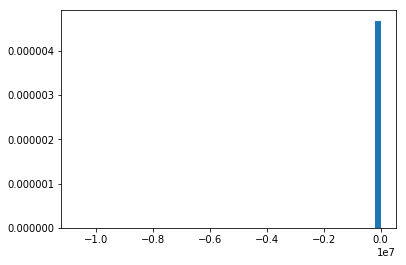

In [47]:
#sns.distplot(trip_duration_all_months_df.duration, color="red") #it is running more time
ar = plt.hist(trip_duration_all_months_df.duration, bins=50, density=True)

* We noticed there are values which are very rare and because of that the histogram above does not give as a lot of information about distribution.

Lets check the most important information about this data:

In [8]:
trip_duration_all_months_df.duration.describe(percentiles=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

count    5.392574e+07
mean     1.604486e+01
std      1.455252e+03
min     -1.066961e+07
50%      1.000000e+01
60%      1.300000e+01
70%      1.600000e+01
80%      2.000000e+01
90%      2.700000e+01
95%      3.600000e+01
99%      6.100000e+01
max      8.852000e+03
Name: duration, dtype: float64

* We observe that the minimum value is less than 0 minutes. It is in reality impossible (probably there was a mistake). Thus, it is reasonable to ignore values less than 0 minutes as well as equal to 0. 
* What about the upper range? We noticed that the maximum value is much higher than 99th percentile. For the further analysis we wanna ignore the outliers. 
--------------

What are the percentiles for a few selected upper bounds?

In [14]:
print("Trip duration less than...")
for score in range(50, 150, 10):
    print("{0} mins -> {1:.3f} percentile".format(score, stats.percentileofscore(trip_duration_all_months_df.duration, score)))

Trip duration less than...
50 mins -> 98.070 percentile
60 mins -> 98.953 percentile
70 mins -> 99.393 percentile
80 mins -> 99.610 percentile
90 mins -> 99.713 percentile
100 mins -> 99.757 percentile
110 mins -> 99.775 percentile
120 mins -> 99.783 percentile
130 mins -> 99.787 percentile
140 mins -> 99.789 percentile


* **It seems rational to conduct analysis for trips under 100 minutes, that represent a significant amount of data.**

In [15]:
#Filtering data
filtered_trip_duration_df = trip_duration_all_months_df[trip_duration_all_months_df.duration.between(0, 100, inclusive=False)]

### Visualization
_________________

In [18]:
# Basic description of the 'duration' column
print("Mode is: {}".format(filtered_trip_duration_df.duration.mode()[0]))
print("Mean is: {}".format(filtered_trip_duration_df.duration.mean()))
print("Std is: {}".format(filtered_trip_duration_df.duration.std()))

Mode is: 6.0
Mean is: 13.575269861894904
Std is: 11.241660106412654


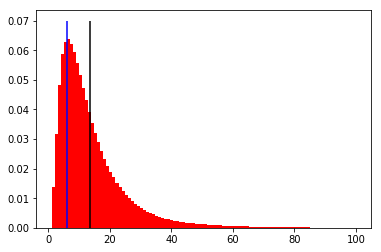

In [62]:
# Plotting histogram (density) of trips duration
h1 = plt.hist(filtered_trip_duration_df.duration, bins=100, density=True, color="red")

# Plotting the mean line (black)
plt.vlines(x=13.6, color = "black", ymin=0, ymax=0.07)

# Plotting the mode line (blue)
plt.vlines(x=6, color = "blue", ymin=0, ymax=0.07)

# Plotting density of data with the fitted curve -- It lasts longer!
# sns.distplot(filtered_trip_duration_df.duration, color="red")

* It is **a right-skewed distribution**, in which the data tends to gradually taper off to a right long tail. 

* Outliers were filtered out previously. The data is from range (0, 100) minutes.
* **Mean = 13.6**
* **Standard deviation = 11.3**
* **The mode = 6**. It means that the trips which lasts 6 minutes are very common. It seems to be reasonable.  

### Analysis for each borough
-------------

* The analysis is based on __PULocationID__ - the location in which the taximeter was engaged.

In [64]:
# Merging prepared data with 'taxi_lookup_file' in order to get information about the broughs
trip_duration_location = pd.merge(filtered_trip_duration_df, taxi_zone_lookup, left_on='PULocationID' , right_on='LocationID')

In [65]:
trip_duration_location.head()

,DOLocationID,PULocationID,duration,LocationID,Borough,Zone,service_zone
0,24.0,41,3.0,41,Manhattan,Central Harlem,Boro Zone
1,74.0,41,10.0,41,Manhattan,Central Harlem,Boro Zone
2,41.0,41,2.0,41,Manhattan,Central Harlem,Boro Zone
3,112.0,41,45.0,41,Manhattan,Central Harlem,Boro Zone
4,223.0,41,29.0,41,Manhattan,Central Harlem,Boro Zone


In [66]:
# Selecting the columns for "duration - borough" analysis. We need only two columns.
trip_duration_borough = trip_duration_location[['duration', 'Borough']]

In [68]:
# Basic statistics for each borough
grouped_trip_duration_borough = trip_duration_borough.groupby(['Borough']).agg({'mean', 'max', 'count'})
grouped_trip_duration_borough

duration                 
                    mean    max     count
Borough                                  
Bronx          18.424800  100.0     51396
Brooklyn       14.793998  100.0    667337
EWR            11.800609   99.0       657
Manhattan      12.298607  100.0  48571418
Queens         32.457887  100.0   3247741
Staten Island  25.436647   98.0       513
Unknown        13.247722  100.0    794003

How it looks like in percentages? Let's see.

In [70]:
# Calculating percentages and Adding them as a new column
all_rows = trip_duration_borough.count()
grouped_trip_duration_borough['percentage'] = grouped_trip_duration_borough['duration']['count'] / all_rows[0] 
grouped_trip_duration_borough

duration                  percentage
                    mean    max     count           
Borough                                             
Bronx          18.424800  100.0     51396   0.000964
Brooklyn       14.793998  100.0    667337   0.012513
EWR            11.800609   99.0       657   0.000012
Manhattan      12.298607  100.0  48571418   0.910719
Queens         32.457887  100.0   3247741   0.060895
Staten Island  25.436647   98.0       513   0.000010
Unknown        13.247722  100.0    794003   0.014888

The most trips is in Manhattan - about 91%.

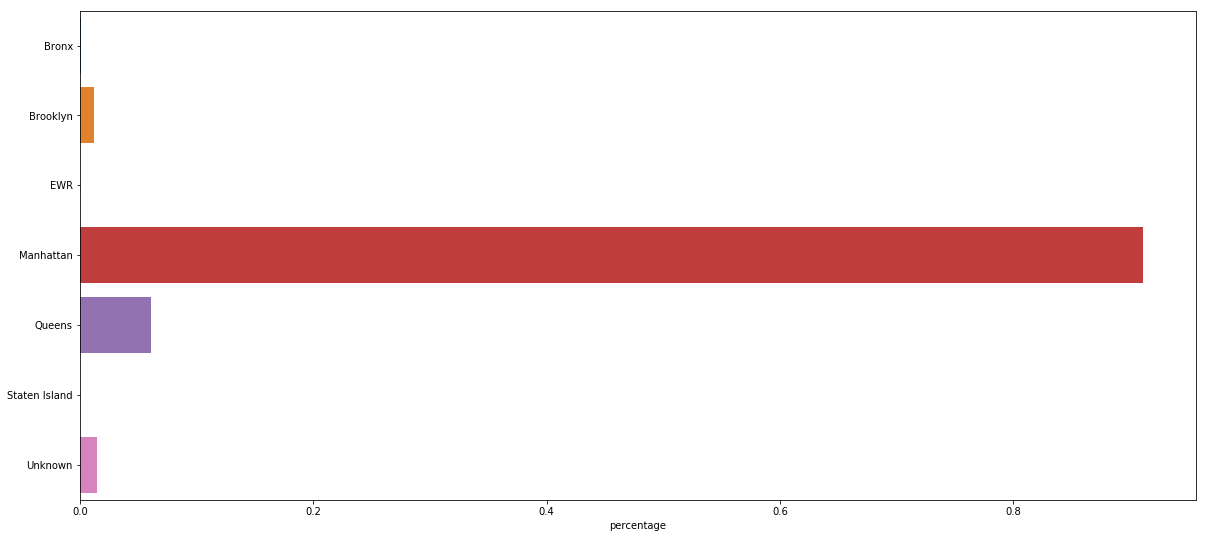

In [98]:
borough_list = ["Bronx", "Brooklyn", "EWR", "Manhattan", "Queens", "Staten Island", "Unknown"]
sns.barplot(grouped_trip_duration_borough.percentage, borough_list)

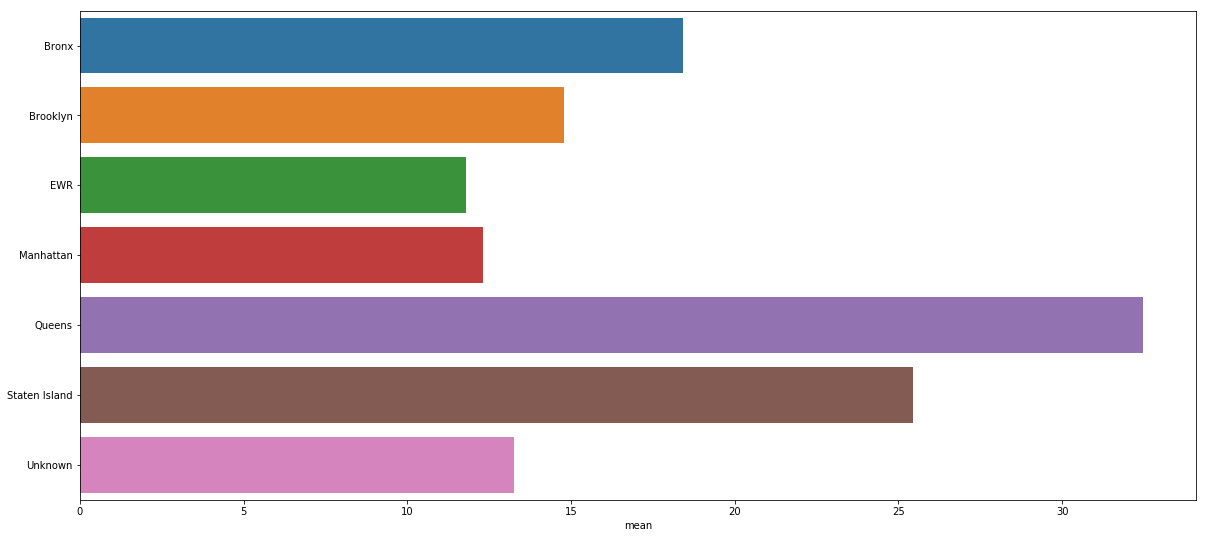

In [110]:
# Plotting the means for each borough
sns.barplot(grouped_trip_duration_borough['duration']['mean'], borough_list)

* In average, the longest trips are in **Queens**.

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


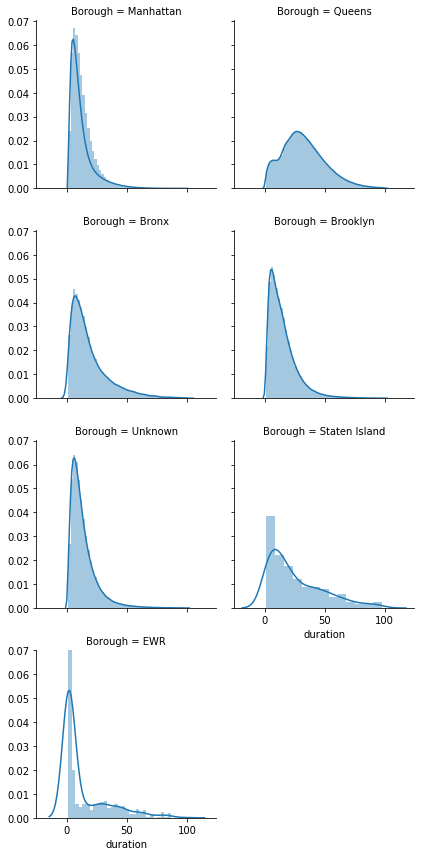

In [112]:
# Plotting the density histogram for each borough; method FacetGrid is doing that automatically
g = sns.FacetGrid(trip_duration_borough, col='Borough', col_wrap=2)
g = g.map(sns.distplot, "duration", kde=True) #kde=True : fitting curve

# g = g.map(plt.hist, "duration", density=True) #histogram from matplotlib library

* It is obvious that all trips do not last the same.

* Distributions of their duration are different for each borough.
However, the brounghs: Bronx, MAnhattan and Brooklyn seems to be quite similar

In [111]:
#TODO: describe in details and compare distributions

In [ ]:
# Make a plot of all distrbutions on one figure